In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tushare as ts


In [11]:
pro = ts.pro_api("7c3490889621b518c6df918d97d49a853e354e4296cb16df747b6e23")

In [12]:
df = pro.daily(trade_date='20190725')

In [30]:
df["value"] = df.amount * df.pct_chg
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,value
0,000032.SZ,20190725,9.49,9.60,9.47,9.56,9.49,0.07,0.7376,12658.35,12075.625,8906.981000
1,000060.SZ,20190725,4.39,4.40,4.35,4.36,4.39,-0.03,-0.6834,129331.65,56462.292,-38586.330353
2,000078.SZ,20190725,3.37,3.38,3.35,3.38,3.37,0.01,0.2967,76681.00,25795.633,7653.564311
3,000090.SZ,20190725,5.66,5.66,5.56,5.61,5.64,-0.03,-0.5319,105582.72,59215.389,-31496.665409
4,000166.SZ,20190725,4.97,4.98,4.93,4.96,4.97,-0.01,-0.2012,268122.48,132793.120,-26717.975744


In [71]:
stock_basic = pro.stock_basic(list_status='L', fields='ts_code,symbol,name,area,industry,list_date')

In [27]:
code_name_map = {ts_code: name for ts_code, name in zip(stock_basic.ts_code, stock_basic.name)}
code_industry_map = {ts_code: name for ts_code, name in zip(stock_basic.ts_code, stock_basic.industry)}
stock_basic.head()

,ts_code,symbol,name,area,industry,list_date
0,000001.SZ,000001,平安银行,深圳,银行,19910403
1,000002.SZ,000002,万科A,深圳,全国地产,19910129
2,000004.SZ,000004,国农科技,深圳,生物制药,19910114
3,000005.SZ,000005,世纪星源,深圳,环境保护,19901210
4,000006.SZ,000006,深振业A,深圳,区域地产,19920427


(array([2.300e+01, 2.695e+03, 8.620e+02, 5.900e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-10.0198 ,  -4.61665,   0.7865 ,   6.18965,  11.5928 ,  16.99595,
         22.3991 ,  27.80225,  33.2054 ,  38.60855,  44.0117 ]),
 <a list of 10 Patch objects>)

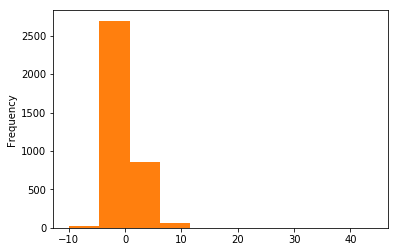

In [74]:
df.pct_chg.plot.hist(bins=20)
plt.hist(df.pct_chg)

In [78]:
df.pct_chg[df.pct_chg > 10]

389     10.0062
519     10.0018
527     10.0232
536     10.0240
636     10.0147
752     15.0342
754     11.5099
755     44.0117
1454    10.0410
1475    10.0118
2447    10.0154
2498    10.0149
2977    10.0157
3012    10.0637
3080    10.2795
Name: pct_chg, dtype: float64

In [81]:
df.pct_chg.head().map(lambda x :x*100)

0    73.76
1   -68.34
2    29.67
3   -53.19
4   -20.12
Name: pct_chg, dtype: float64

1. 仪表图(涨幅热度) Gauge  涨幅度划分为5个部分  < -5, <1, -1 < > 1, > 5 

In [114]:
from pyecharts import options as opts
from pyecharts.charts import Page, Pie

def split(value):
    if value < -5:
        return 1
    elif value < -1:
        return 2
    elif value < 1:
        return 3
    elif value < 5:
        return 4
    else:
        return 5

df_pct_chg = df.pct_chg.map(split)



def pie_base() -> Pie:
    c = (
        Pie()
        .add("", df_pct_chg.value_counts().to_dict().items())
        .set_global_opts(title_opts=opts.TitleOpts(title="Pie-基本示例"))
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    )
    return c

pie_base().render_notebook()

In [117]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk


date_format = "%Y-%m-%dT%H:%M:%S.%f+0800"
es_host = "127.0.0.1:9200"
es = Elasticsearch([es_host])

ts.set_token("7c3490889621b518c6df918d97d49a853e354e4296cb16df747b6e23") 

data = ts.pro_bar(ts_code='000001.SH', asset='I', start_date='20120101')
data.trade_date = pd.to_datetime(data.trade_date)
index_name = "index-" + data.ts_code[0].lower()

bulk_lst = []
for idx, value in enumerate(data.values, start=1):
    doc = {}
    for col_name, v in zip(data.columns, value):
        doc[col_name] = v

    doc["trade_date"] = doc["trade_date"].strftime(date_format)
    doc_id = "-".join([doc["ts_code"], doc["trade_date"]])
    bulk_lst.append({
                    "_index": index_name,
                    "_id": doc_id,
                    "_type": "doc",
                    "_source": doc,
                    })

    if idx % 100 == 0:
        print(bulk(es, bulk_lst, stats_only=True))
        bulk_lst = []

(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
